In [1]:
%matplotlib inline
%precision 16
from __future__ import print_function
from six.moves import range
import numpy
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

Vincent Zhao

# HW 6: Hyperbolic Problems

## Question 1 - The Lax-Wendroff & Upwind Methods

Let's consider the advection equation

$$
    u_t + a u_x = 0 ~~~~\mbox{on }[0,L]
$$

with $a,L \in \mathbb R$, and periodic boundary conditions.

**(a)** [10] Implement the Upwind method to solve the advection equation.  Choose $\Delta t$ in a way that you reach the final time $t_f$ to machine accuracy (the resulting time, not the solution).  Also make sure to consider advection velocities that are both positive and negative.

In [2]:
def solve_advection_UPW(a, m, L, t_0, t_final, U_0):
    """Solve the advection equation on a periodic domain using the upwind method
    
    :Input:
     - *a* (float) Advection speed
     - *m* (int) Number of points use to discretize the domain.  Note that
       the total number of points is *m+1*.
     - *L* (float) Length of half of the domain
     - *t_0* (float) Starting time
     - *t_final* (float) Time to integrate to
     - *U_0* (numpy.ndarray) Initial condition at time t_0, should be m+1
     
    :Output:
     - (numpy.ndarray) Solution at time t_final.  Note that this vector should m+1
    """
    
    delta_x = L / float(m + 1)
    
    cfl = 0.90
    delta_t = numpy.abs(cfl * delta_x / a)
    t = numpy.arange(t_0, t_final, delta_t)
    
    U = U_0
    U_new = numpy.empty(U.shape)
    
    if a > 0:
        while t_0 < t_final:
            U_new[0] = U[0] - (a*delta_t) / delta_x * (U[0] - U[-1])
            #U_new[1:-1] = U[1:-1] - delta_t / delta_x * (U[1:-1] - U[:-2])
            #U_new[-1] = U[-1] - delta_t / delta_x * (U[-1] - U[-2])
            #Periodic boundaries will wrap in vectorized operation anyways
            U_new[1:] = U[1:] - (a*delta_t) / delta_x * (U[1:] - U[:-1])
            U = U_new.copy()
            t_0 += delta_t
    else:
        while t_0 < t_final:
            U_new[-1] = U[-1] - (a*delta_t) / delta_x * (U[0] - U[-1])
            #U_new[1:-1] = U[1:-1] - delta_t / delta_x * (U[1:-1] - U[:-2])
            #U_new[-1] = U[-1] - delta_t / delta_x * (U[-1] - U[-2])
            #Periodic boundaries will wrap in vectorized operation anyways
            U_new[:-1] = U[:-1] - (a*delta_t) / delta_x * (U[1:] - U[:-1])
            U = U_new.copy()
            t_0 += delta_t  
    
    return U

Error upwind = 0.08976435119469459
Error upwind = 0.08976435119469459


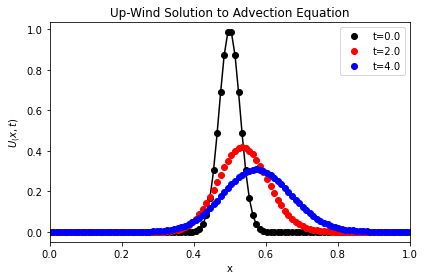

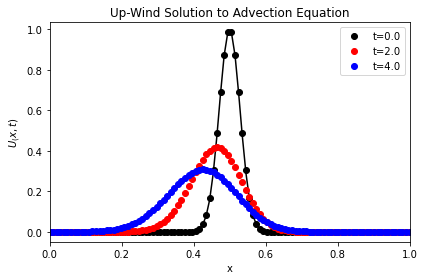

In [3]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Discretization and output times
m = 100
x = numpy.linspace(0.0, L, m + 2)
x_fine = numpy.linspace(0.0, L, 100)
delta_x = L / float(m + 1)
output_times = (0.0, 2.0, 4.0)

for a in [-2.0, 2.0]:
    # Solve
    U = numpy.empty((len(output_times), m + 2))
    U[0, :] = u_true(x, 0.0, a)
    for (n, t) in enumerate(output_times[1:]):
        U[n + 1, :] = solve_advection_UPW(a, m, L, output_times[n], t, U[n,:])

    error = numpy.linalg.norm(delta_x * (U[-1, :] - u_true(x, output_times[-1], a)), ord=1)
    print("Error upwind = %s" % error)

    # Plot some of the results
    colors = ['k', 'r', 'b', 'g', 'c', 'y']
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x_fine, u_true(x_fine, t, a), 'k-')
    for (n, t) in enumerate(output_times):
        axes.plot(x, U[n, :], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
        axes.set_xlabel("x")
        axes.set_ylabel("$U_(x,t)$")
        axes.set_title("Up-Wind Solution to Advection Equation")
        axes.set_xlim([0, L])
        axes.legend()
    plt.tight_layout()
plt.show()

**(b)** [10] Implement the Lax-Wendroff to solve the advection equation with the same requirements as part (a).  Note that the number of grid points in the test is twice that of the above.

In [4]:
def solve_advection_LW(a, m, L, t_0, t_final, U_0):
    """Solve the advection equation on a periodic domain using the Lax-Wendroff method
    
    :Input:
     - *a* (float) Advection speed
     - *m* (int) Number of points use to discretize the domain.  Note that
       the total number of points is *m+1*.
     - *L* (float) Length of half of the domain
     - *t_0* (float) Starting time
     - *t_final* (float) Time to integrate to
     - *U_0* (numpy.ndarray) Initial condition at time t_0, should be m+1
     
    :Output:
     - (numpy.ndarray) Solution at time t_final.  Note that this vector should m+1
    """
    
    delta_x = L / float(m + 1)
    cfl = 0.8
    delta_t = numpy.abs(cfl * delta_x / a)


    U = U_0
    U_new = numpy.empty(U.shape)

    while t_0 < t_final:
        U_new[0] = U[0] - (a*delta_t) / (2.0 * delta_x) * (U[1] - U[-1]) \
                        + ((a**2)*(delta_t**2)) / (2.0 * delta_x**2) * (U[1] - 2.0 * U[0] + U[-1])
        U_new[1:-1] = U[1:-1] - (a*delta_t) / (2.0 * delta_x) * (U[2:] - U[:-2]) \
                              + ((a**2)*(delta_t**2)) / (2.0 * delta_x**2) * (U[2:] - 2.0 * U[1:-1] + U[:-2])
        U_new[-1] = U[-1] - (a*delta_t) / (2.0 * delta_x) * (U[0] - U[-2]) \
                          + ((a**2)*(delta_t**2)) / (2.0 * delta_x**2) * (U[0] - 2.0 * U[-1] + U[-2])
        U = U_new.copy()
        t_0 += delta_t
    
    
    return U

Error LW = 0.08349722809857058
Error LW = 0.08349722809857063


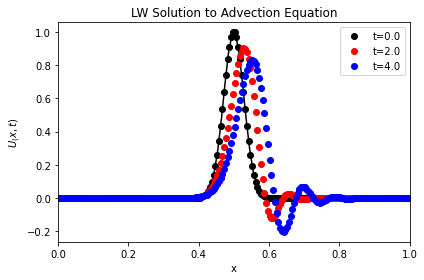

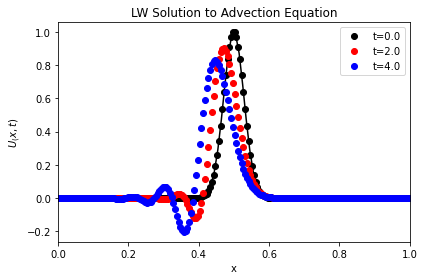

In [5]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Discretization and output times
m = 200
x = numpy.linspace(0.0, L, m + 2)
x_fine = numpy.linspace(0.0, L, 100)
delta_x = L / float(m + 1)
output_times = (0.0, 2.0, 4.0)

for a in [-2.0, 2.0]:
    # Solve
    U = numpy.empty((len(output_times), m + 2))
    U[0, :] = u_true(x, 0.0, a)
    for (n, t) in enumerate(output_times[1:]):
        U[n + 1, :] = solve_advection_LW(a, m, L, output_times[n], t, U[n,:])

    error = numpy.linalg.norm(delta_x * (U[-1, :] - u_true(x, output_times[-1], a)), ord=1)
    print("Error LW = %s" % error)

    # Plot some of the results
    colors = ['k', 'r', 'b', 'g', 'c', 'y']
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x_fine, u_true(x_fine, t, a), 'k-')
    for (n, t) in enumerate(output_times):
        axes.plot(x, U[n, :], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
        axes.set_xlabel("x")
        axes.set_ylabel("$U_(x,t)$")
        axes.set_title("LW Solution to Advection Equation")
        axes.set_xlim([0, L])
        axes.legend()
    plt.tight_layout()
plt.show()

**(c)** [5] Set the final time $t_{final} = 0.1$ and show that the Lax-Wendroff method is second order accurate and the Upwind method first order accurate.

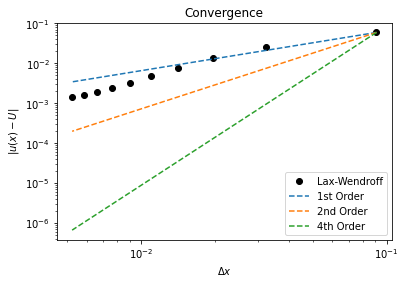

In [6]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Compute the error as a function of delta_x
m_range = numpy.arange(10, 210, 20)
delta_x = numpy.empty(m_range.shape)
error = numpy.empty(m_range.shape[0])

output_times = (0.0, 0.1)

for (i, m) in enumerate(m_range):
    
    x = numpy.linspace(0.0, L, m + 2)
    x_fine = numpy.linspace(0.0, L, 100)
    delta_x[i] = L / float(m + 1)
    

    for a in [-2.0, 2.0]:
    # Solve
        
        U = numpy.empty((len(output_times), m + 2))
        U[0, :] = u_true(x, 0.0, a)

        U[1, :] = solve_advection_LW(a, m, L, 0.0, 0.1, U[0,:])
        error[i] = numpy.linalg.norm(delta_x[i] * (U[-1, :] - u_true(x, 0.1, a)), ord=1)


order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error[:], 'ko', label="Lax-Wendroff")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, '--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, '--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 4.0) * delta_x**4.0, '--', label="4th Order")
axes.legend(loc=4)
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

plt.show()

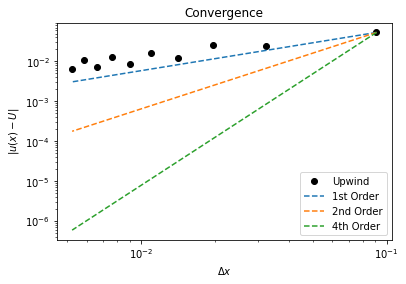

In [7]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Compute the error as a function of delta_x
m_range = numpy.arange(10, 210, 20)
delta_x = numpy.empty(m_range.shape)
error = numpy.empty(m_range.shape[0])

output_times = (0.0, 0.1)

for (i, m) in enumerate(m_range):
    
    x = numpy.linspace(0.0, L, m + 2)
    x_fine = numpy.linspace(0.0, L, 100)
    delta_x[i] = L / float(m + 1)
    

    for a in [-2.0, 2.0]:
    # Solve
        
        U = numpy.empty((len(output_times), m + 2))
        U[0, :] = u_true(x, 0.0, a)

        U[1, :] = solve_advection_UPW(a, m, L, 0.0, 0.1, U[0,:])
        error[i] = numpy.linalg.norm(delta_x[i] * (U[-1, :] - u_true(x, 0.1, a)), ord=1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error[:], 'ko', label="Upwind")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, '--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, '--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 4.0) * delta_x**4.0, '--', label="4th Order")
axes.legend(loc=4)
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

plt.show()

**(d)** [5] What happens to the convergence of both methods if the initial condition is a step discontinuity?  Why might this be?

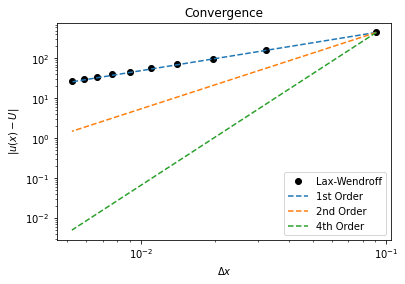

In [8]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Compute the error as a function of delta_x
m_range = numpy.arange(10, 200, 20)
delta_x = numpy.empty(m_range.shape)
error = numpy.empty((m_range.shape[0]))

for (i, m) in enumerate(m_range):
    
    x = numpy.linspace(0.0, L, m + 2)
    x_fine = numpy.linspace(0.0, L, 100)
    delta_x[i] = L / float(m + 1)
    output_times = (0.0, 0.1)
    
    # Solve
    U = numpy.empty((len(output_times), m + 2))
    U[0, :] = u_true(x, 0.0, 2)
    U[0,:][1:9] = numpy.empty(1)
    for (n, t) in enumerate(output_times[1:]):
        U[n + 1, :] = solve_advection_LW(2, m, L, output_times[n], t, U[n,:])
    
    error[i] = numpy.linalg.norm(delta_x[i] * (U[-1, :] - u_true(x, output_times[-1], 2)), ord=1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error[:], 'ko', label="Lax-Wendroff")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, '--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, '--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 4.0) * delta_x**4.0, '--', label="4th Order")
axes.legend(loc=4)
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

plt.show()

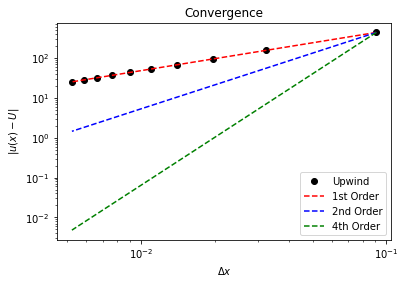

In [9]:
L = 1.0
beta = 600.0
u_true = lambda x, t, a: numpy.exp(- beta * (numpy.mod(x - a * t, L) - 0.5)**2)

# Compute the error as a function of delta_x
m_range = numpy.arange(10, 200, 20)
delta_x = numpy.empty(m_range.shape)
error = numpy.empty(m_range.shape[0])

for (i, m) in enumerate(m_range):
    
    x = numpy.linspace(0.0, L, m + 2)
    x_fine = numpy.linspace(0.0, L, 100)
    delta_x[i] = L / float(m + 1)
    output_times = (0.0, 0.1)
    
    # Solve
    U = numpy.empty((len(output_times), m + 2))
    U[0, :] = u_true(x, 0.0, 2)
    U[0,:][1:9] = numpy.empty(1)
    for (n, t) in enumerate(output_times[1:]):
        U[n + 1, :] = solve_advection_UPW(2, m, L, output_times[n], t, U[n,:])
    
    error[i] = numpy.linalg.norm(delta_x[i] * (U[-1, :] - u_true(x, output_times[-1], 2)), ord=1)

titles = ["Convergence"]
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error[:], 'ko', label="Upwind")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 4.0) * delta_x**4.0, 'g--', label="4th Order")
axes.legend(loc=4)
axes.set_title(titles[0])
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

plt.show()

Both methods became first order accuracy probably because we may come across the oscillation and a discontinuity may force us to a first order convergence

## Question 2 - Modified Equations

**(a)** [15] Show that the modified equation for the _Lax-Wendroff_ method is indeed

$$
    v_t + a v_x = -\frac{1}{6} a \Delta x^2 \left( 1 - \left(\frac{a \Delta t}{\Delta x}\right)^2 \right) v_{xxx}.
$$
to second order.

#### Answer to Question 2 (a)

The _Lax-Wendroff_ method can be written as below:

$$
U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})  + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_{j+1} - 2 U^n_{j} + U^n_{j-1})
$$

Since it is a discrete one we can first replace our $U$ by the continuous function $v(x,t)$ and get:

$$
\begin{aligned}
v(x, t + \Delta t) =& v(x,t) - \frac{a \Delta t}{2\Delta x} (v(x+\Delta x,t) - v(x-\Delta x,t))\\ &+ \frac{a^2 \Delta t^2}{2 \Delta x^2} (v(x+\Delta x,t) - 2v(x,t) + v(x-\Delta x,t))
\end{aligned}
$$

Then if we want to know it is indeed to second order we can expand the whole thing by Taylor series and get something below:

$$
\begin{aligned}
v_t + \frac{\Delta t}{2} v_{tt} + \frac{\Delta t^2}{6} v_{ttt} + \cdots + a \left( v_x + \frac{\Delta x}{2} v_{xx} + \cdots \right ) - a^2 \Delta t \left ( \frac{\Delta x}{6} v_{xxx} + \cdots \right ) = 0\\
\implies v_{t} + av_{x} = \frac{1}{2}(a \Delta x v_{xx} - \Delta t v_{tt} + \frac{a v}{\Delta x} - a \Delta t v_{xt}) - \frac{1}{4}(a\Delta t^{2}v_{xtt} + a\Delta t \Delta x v_{xxt}) + \frac{1}{6} (a \Delta x^2 v_{xxx} - \Delta t^2 v_{ttt})
\end{aligned}
$$

If we differentiate w.r.t $x$ and $t$ with $v_{ttt}=a^3 v_{xxx}$ by hand can get:

$$
    v_t + a v_x = -\frac{1}{6} a \Delta x^2 \left( 1 - \left(\frac{a \Delta t}{\Delta x}\right)^2 \right) v_{xxx}.
$$


**(b)** [15] Determine the modified equation on which the discretization

$$
    U_j^{n+1} = U_j^n - \frac{a \Delta t}{2 \Delta x}\left(U_j^n - U_{j-1}^n + U_j^{n+1} - U_{j-1}^{n+1} \right)
$$

is second-order accurate. Comment on whether the method's error is dominantly dispersive or dissipative.

#### Answer to Question 2 (b)

Replace the all the $U$s by v(x,t)s
$$
v(x, t + \Delta t) = v(x, t) - \frac{a \Delta t}{2\Delta x} \left ( v(x, t) - v(x - \Delta x, t) + v(x, t + \Delta t) - v(x - \Delta x, t + \Delta t) \right)
$$

Do the Taylor expansion on the equation above and get:

$$
\begin{aligned}
v_t + \frac{\Delta t}{2} v_{tt} + \frac{\Delta t^2}{6} v_{ttt} + \cdots + a \left( -\frac{v}{2 \Delta x} + v_{x} + \frac{\Delta x v_{xx}}{2} - \frac{\Delta x^{2}}{6} v_{xxx} - \frac{\Delta t v_{xt}}{2} - \frac{\Delta t^{2} v_{xtt}}{4} - \frac{\Delta x \Delta t v_{xxt}}{4} \cdots \right ) = 0\\
\implies v_{t} + av_{x} = \frac{1}{2}(a \Delta x v_{xx} - \Delta t v_{tt} + \frac{a v}{\Delta x} - a \Delta t v_{xt}) - \frac{1}{4}(a\Delta t^{2}v_{xtt} + a\Delta t \Delta x v_{xxt}) + \frac{1}{6} (a \Delta x^2 v_{xxx} - \Delta t^2 v_{ttt})
\end{aligned}
$$


If we differentiate wrt $x$ and $t$ and with $v_{tt} = a^{2}v_{xx}$ by hand will give us:
$$
v_t + a v_x = \frac{1}{2} a \Delta x \left( (1 - \frac{a \Delta t}{\Delta x})v_{xx} + \frac{v}{\Delta x^2} - \frac{\Delta t v_{xt}}{\Delta x} \right)  + \mathcal{O}(\Delta x^2, \Delta t^2)
$$

The 2nd derivative will cancel out the error

## Question 3 - Burger's Equation

Consider the non-linear and hyperbolic _Burger's equation_ 

$$
    u_t + uu_x = 0, ~~~~ \mbox{on } [0,L]
$$

with initial condition $u(x,0) = x$.

**(a)** [10] Do you expect that a forward in time, centered in space (FTCS) method would capture or represent the characteristics of this equation? To which extent do you expect a FTCS numerical method to yield good results?  Backup your conclusions with analysis (for instance solve the equation).

#### Answer to Question 3(a)

Boundary condition is: $u(0,t) = 0$

We know that $\frac{\partial x}{\partial t} = u$ and $u_t = 0$, after integration, we can know:

$$
\begin{aligned}
u&=c_1\\
x &= c_1t+c_2 = ut+c_2
\end{aligned}
$$

Thus, $x - ut = c_2$, $c_1(x-u(x,0)\cdot0) = x$ 

We then can know:

$$
u(x,t) = \frac{x}{1+t}
$$

By FTCS method, we have 
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}+\frac{F_{i+1}^{n}-F_{i-1}^{n}}{2 \Delta x} = 0
$$

We'd love to choose a relatively small $\Delta t$ since the explict scheme sometimes needs very small $\Delta t$s for stability and also i think we may come across some problem while taking this specific time step FTCS

**(b)** [20] Derive a modification of the _Upwind_ method that takes into account the non-constant speed, implement the new method and use it to solve the equation with initial condition

$$
    u(x,0) = x,
$$

with final time $t_{final} = 1.0$.  In this case consider a domain with length $L$ s.t. $x \in [0, L]$ with outflow boundary conditions.

In [10]:
def solve_burgers_UPW(m, L, t_0, t_final, U_0):
    """Solve Burger's equation using an upwind approach
    
    :Input:
     - *m* (int) Number of points to use to discretize space.
     - *L* (float) Length of domain s.t. x \in [0, L]
     - *t_0* (float) Initial time, u(x, t_0) = U_0
     - *t_final* (float) Final integration time to return
     - *U_0* (ndarray) Initial condition s.t. u(x, t_0) = U_0
     
    :Output:
     - (numpy.ndarray) Approximate solution at time t_final.
    """
    delta_x = L / float(m + 1)
    cfl = 0.05
    delta_t = cfl * delta_x

    U = U_0
    U_new = numpy.empty(U.shape)
    
    while t_0 < t_final:
        
        U_new[0] = U[0]/(1+((delta_t / delta_x) * (U[0] - U[-1])))
        U_new[1:-1] = U[1:-1]/(1+((delta_t / delta_x) * (U[1:-1] - U[:-2])))
        U_new[-1] = U[-1]/(1+((delta_t / delta_x) * (U[-1] - U[-2])))
        
        U = U_new.copy()
        t_0 += delta_t
    
    return U

Error UPW = 0.0012340600575894284


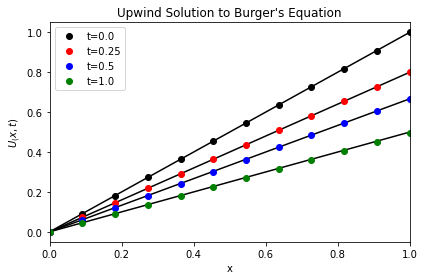

In [11]:
# Equation dependent parameters
L = 1.0
t_0     = 0.0
t_final = 1.0

u_true = lambda x, t: x / (1 + t)

# Discretization and output times
m            = 10
delta_x      = L / float(m + 1)
x            = numpy.linspace(0.0, L+delta_x, m + 3)
x_fine       = numpy.linspace(0.0, L, 100)
output_times = (0.0, 0.25, 0.5, 1.0)

# Solve
U_UPW       = numpy.empty((len(output_times), m + 3))
U_UPW[0, :] = u_true(x, 0.0)

for (n, t) in enumerate(output_times[1:]):
    U_UPW[n + 1, :] = solve_burgers_UPW(m, L, output_times[n], t, U_UPW[n,:])
    
error = numpy.linalg.norm(delta_x * (U_UPW[-1, :-1] - u_true(x[:-1],t_final)), ord=1)
print("Error UPW = %s" % error)

# Plot some of the results
colors = ['k', 'r', 'b', 'g', 'c']
fig = plt.figure()
axes_BE = fig.add_subplot(1, 1, 1)
for (n, t) in enumerate(output_times):
    axes_BE.plot(x_fine, u_true(x_fine, t), 'k-')
    axes_BE.plot(x[:-1], U_UPW[n, :-1], "o%s" % colors[n], label='t=%s' % numpy.round(t, 4))
    axes_BE.set_xlabel("x")
    axes_BE.set_ylabel("$U_(x,t)$")
    axes_BE.set_title("Upwind Solution to Burger's Equation")
    axes_BE.set_xlim([0, L])
    axes_BE.legend()
    
plt.tight_layout()
plt.show()

**(c)** [10] Plot the convergence of the above method.

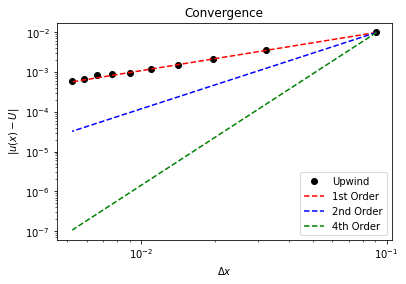

In [12]:
L = 1.0
t_0     = 0.0
t_final = 1.0
u_true = lambda x, t: x / (1 + t)

# Compute the error as a function of delta_x
m_range = numpy.arange(10, 200, 20)
delta_x = numpy.empty(m_range.shape)
error = numpy.empty(m_range.shape[0])

for (i, m) in enumerate(m_range):
    
    x = numpy.linspace(0.0, L+delta_x[i], m + 3)
    x_fine = numpy.linspace(0.0, L, 100)
    delta_x[i] = L / float(m + 1)
    output_times = (0.0, 0.25, 0.5, 1.0)
    
    # Solve
    U_UPW = numpy.empty((len(output_times), m + 3))
    U_UPW[0, :] = u_true(x, 0.0)
    U[0,:][1:9] = numpy.empty(1)
    for (n, t) in enumerate(output_times[1:]):
        U_UPW[n + 1, :] = solve_burgers_UPW(m, L, output_times[n], t, U_UPW[n,:])
        
    error[i] = numpy.linalg.norm(delta_x[i] * (U_UPW[-1, :-1] - u_true(x[:-1],t_final)), ord=1)


order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error[:], 'ko', label="Upwind")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 4.0) * delta_x**4.0, 'g--', label="4th Order")
axes.legend(loc=4)
axes.set_title('Convergence')
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

plt.show()